# TP02 — Forward Kinematics (Exercises 4-6)

**GEII3 — Industrie 4.0: Robotique | Lab Session 2 - Part 2**

**Session 2**: Advanced topics - PUMA 560, comparative analysis, workspace & singularities

---

In [ ]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi, atan2, sqrt
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D

try:
    import roboticstoolbox as rtb
    from spatialmath import SE3
    RTB_AVAILABLE = True
    print(f"✓ RTB version: {rtb.__version__}")
except ImportError:
    RTB_AVAILABLE = False
    print("⚠ RTB not available")

np.set_printoptions(precision=4, suppress=True)

# Import helper functions from Python file
from tp_02_fk_helpers import * # type: ignore 

# Define robot parameters from previous exercises
# (needed for Exercise 5 comparative analysis)

# 2R Planar robot (from Exercise 1)
dh_2r_standard = [
    # TODO: Complete based on your previous session derivation
]
q_2r = np.array([np.deg2rad(30), np.deg2rad(45)])

# 3R Anthropomorphic robot (from Exercise 2)
dh_3r_standard = [
    # TODO: Complete based on your previous session derivation
]
q_test = np.array([np.deg2rad(45), np.deg2rad(30), np.deg2rad(-45)])

print("✓ Session 2 ready\n")

✓ RTB version: 1.1.1
✓ Helper functions loaded from tp_02_fk_helpers.py
✓ Session 2 ready



---

# Exercise 4: PUMA 560 (6-DOF Industrial Robot)

**Estimated time**: 120 minutes (Session 2)

## Problem Description

The **PUMA 560** (Programmable Universal Machine for Assembly) is a classic 6-DOF industrial robot designed by Unimation in 1978. It has been extensively used in research and education.

**Configuration**: RRR (shoulder-elbow) + RRR (spherical wrist)

**Standard DH Parameters** (from literature):

| Joint i | $\theta_i$ | $d_i$ (m) | $a_i$ (m) | $\alpha_i$ | Type |
|---------|-----------|-----------|-----------|------------|------|
| 1       | $q_1$     | 0         | 0         | 90°        | R    |
| 2       | $q_2$     | 0         | 0.4318    | 0°         | R    |
| 3       | $q_3$     | 0.15      | 0.0203    | -90°       | R    |
| 4       | $q_4$     | 0.4318    | 0         | 90°        | R    |
| 5       | $q_5$     | 0         | 0         | -90°       | R    |
| 6       | $q_6$     | 0         | 0         | 0°         | R    |

**Key features**:
- First 3 joints: positioning (RRR anthropomorphic)
- Last 3 joints: orientation (spherical wrist)
- Kinematic decoupling simplifies inverse kinematics

---

## Task 4.1: Understanding the Structure (15 min)

### Study Questions:

**Q1**: Why does Joint 1 have $\alpha_1 = 90°$?

_Your answer:_


**Q2**: Identify the "wrist center" point. Why is it important?

_Your answer:_


**Q3**: What does "spherical wrist" mean? Which joints form it?

_Your answer:_


---

## Task 4.2: Implementation with Standard DH (30 min)


  PUMA 560 - STANDARD DH IMPLEMENTATION

[Home] q = [0 0 0 0 0 0]°
  Position: [0.4521, -0.1500, 0.4318]
  Orientation (first column): [1.0000, 0.0000, 0.0000]

[Test 1] q = [  0  45 -45   0  45   0]°
  Position: [0.3256, -0.1500, 0.7371]
  Orientation (first column): [0.7071, 0.0000, 0.7071]

[Test 2] q = [ 59  29 -59  45  29  45]°
  Position: [0.4336, 0.4510, 0.5797]
  Orientation (first column): [-0.7486, 0.5694, 0.3397]


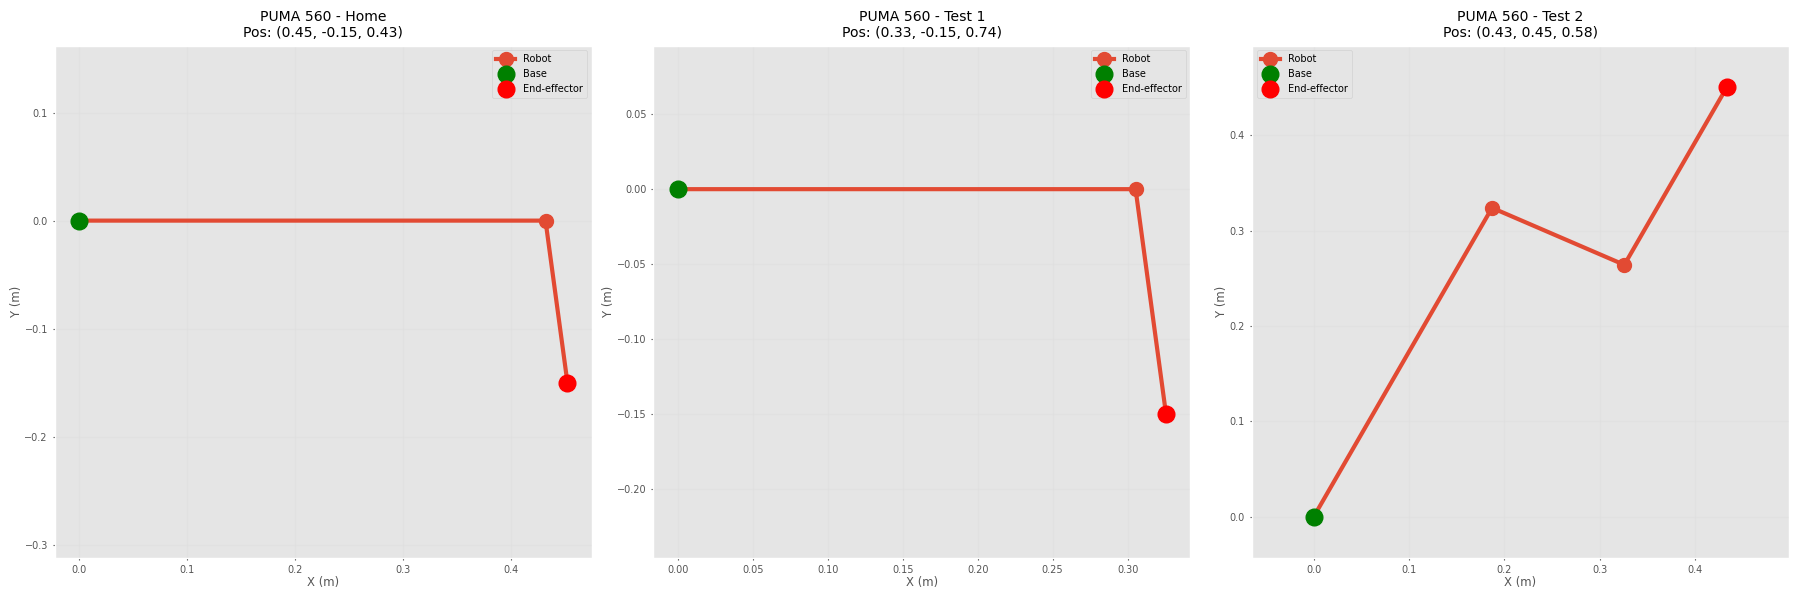

In [ ]:
# PUMA 560 DH parameters (Standard convention)
# Based on standard literature values

dh_puma_std = [
    # TODO : Complete based on standard DH parameters for PUMA 560
    # Format: (theta_offset, d_offset, a, alpha, joint_type)
]

# Define test configurations
q_puma_home = np.array([0, 0, 0, 0, 0, 0])
q_puma_test1 = np.array([0, pi/4, -pi/4, 0, pi/4, 0])
q_puma_test2 = np.array([pi/3, pi/6, -pi/3, pi/4, pi/6, pi/4])

configs = {
    'Home': q_puma_home,
    'Test 1': q_puma_test1,
    'Test 2': q_puma_test2
}

print("\n" + "="*80)
print("  PUMA 560 - STANDARD DH IMPLEMENTATION")
print("="*80)

results = {}

for name, q in configs.items():
    T, T_list = fk_dh(dh_puma_std, q, 'standard')
    results[name] = (T, T_list)
    
    pos = extract_position(T)
    rot = extract_rotation(T)
    
    print(f"\n[{name}] q = {np.rad2deg(q).astype(int)}°")
    print(f"  Position: [{pos[0]:.4f}, {pos[1]:.4f}, {pos[2]:.4f}]")
    print(f"  Orientation (first column): [{rot[0,0]:.4f}, {rot[1,0]:.4f}, {rot[2,0]:.4f}]")

# Visualize configurations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, (T, T_list)) in enumerate(results.items()):
    plot_robot_2d(T_list, axes[idx], 
                  title=f"PUMA 560 - {name}\nPos: ({T[0,3]:.2f}, {T[1,3]:.2f}, {T[2,3]:.2f})",
                  draw_frames=False)

plt.tight_layout()
plt.show()

## Task 4.3: Modified DH Implementation (20 min)

Convert to Modified DH convention and compare.

In [ ]:
# PUMA 560 with Modified DH (Craig's convention)
# This is what RTB uses!

dh_puma_mdh = [
    # TODO : Complete based on standard DH parameters for PUMA 560
    # Format: (theta_offset, d_offset, a, alpha, joint_type)
]

# Compute FK for test configuration
T_mdh, _ = fk_dh(dh_puma_mdh, q_puma_test1, 'modified')
T_std, _ = fk_dh(dh_puma_std, q_puma_test1, 'standard')

print("\n" + "="*80)
print("  PUMA 560 - COMPARING DH CONVENTIONS")
print("="*80)
print(f"Configuration: {np.rad2deg(q_puma_test1).astype(int)}°")

print("\nStandard DH result:")
print(T_std)

print("\nModified DH result:")
print(T_mdh)

diff = np.max(np.abs(T_std - T_mdh))
print(f"\nMaximum difference: {diff:.2e}")

if diff < 1e-6:
    print("✓ Both conventions produce identical results!")
else:
    print("⚠ Conventions differ - review DH table conversion")


  PUMA 560 - COMPARING DH CONVENTIONS
Configuration: [  0  45 -45   0  45   0]°

Standard DH result:
[[ 0.7071 -0.     -0.7071  0.3256]
 [ 0.      1.     -0.     -0.15  ]
 [ 0.7071 -0.      0.7071  0.7371]
 [ 0.      0.      0.      1.    ]]

Modified DH result:
[[ 0.7071 -0.     -0.7071  0.3256]
 [ 0.      1.     -0.     -0.4318]
 [ 0.7071 -0.      0.7071  0.4553]
 [ 0.      0.      0.      1.    ]]

Maximum difference: 2.82e-01
⚠ Conventions differ - review DH table conversion


## Task 4.4: Validation with RTB (15 min)

Compare with Peter Corke's built-in PUMA 560 model.

In [4]:
if RTB_AVAILABLE:
    # Load built-in PUMA 560 model
    puma = rtb.models.DH.Puma560()
    
    print("\n" + "="*80)
    print("  RTB PUMA 560 MODEL")
    print("="*80)
    print(puma)
    
    # Show DH parameters
    print("\nDH Parameters (Modified convention):")
    print(puma.links)
    
    # Compute FK for all test configs
    print("\n" + "="*80)
    print("  VALIDATION AGAINST RTB")
    print("="*80)
    
    for name, q in configs.items():
        T_rtb = puma.fkine(q)
        T_manual = results[name][0]
        
        print(f"\n[{name}]")
        match = compare_with_rtb(T_manual, T_rtb, verbose=False)
        if match:
            print("  ✓ Manual implementation matches RTB")
        else:
            print("  ✗ Discrepancy detected")
    
    # 3D visualization (optional)
    print("\n--- Optional: 3D Visualization ---")
    print("Uncomment the line below to see 3D plot:")
    # puma.plot(q_puma_test1, backend='pyplot', block=True)
    
else:
    print("RTB not available - skipping validation")


  RTB PUMA 560 MODEL
DHRobot: Puma 560 (by Unimation), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌─────┬────────┬────────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ   │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼────────┼────────┼────────┼─────────┼────────┤
│  q1 │ 0.6718 │      0 │  90.0° │ -160.0° │ 160.0° │
│  q2 │      0 │ 0.4318 │   0.0° │ -110.0° │ 110.0° │
│  q3 │   0.15 │ 0.0203 │ -90.0° │ -135.0° │ 135.0° │
│  q4 │ 0.4318 │      0 │  90.0° │ -266.0° │ 266.0° │
│  q5 │      0 │      0 │ -90.0° │ -100.0° │ 100.0° │
│  q6 │      0 │      0 │   0.0° │ -266.0° │ 266.0° │
└─────┴────────┴────────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬─────┬──────┬───────┬─────┬──────┬─────┐
│ name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├──────┼─────┼──────┼───────┼─────┼──────┼─────┤
│   qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│   qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│   qn │  0° │  45° │  180° │  0° │  45° │  0° │
│   qs │  0° │  0°  │ -90°  │ 

## Task 4.5: Wrist Center Analysis (20 min)

The wrist center is a key point for kinematic decoupling.

In [5]:
def compute_wrist_center(dh_params, q):
    """
    For PUMA 560, wrist center is at joint 4.
    Compute T_0^4 (first 4 joints only).
    """
    dh_wrist = dh_params[:4]  # First 4 joints
    q_wrist = q[:4]
    T_wrist, _ = fk_dh(dh_wrist, q_wrist, 'standard')
    return extract_position(T_wrist)

print("\n" + "="*80)
print("  WRIST CENTER ANALYSIS")
print("="*80)

for name, q in configs.items():
    wc = compute_wrist_center(dh_puma_std, q)
    ee = extract_position(results[name][0])
    
    print(f"\n[{name}]")
    print(f"  Wrist center: [{wc[0]:.4f}, {wc[1]:.4f}, {wc[2]:.4f}]")
    print(f"  End-effector: [{ee[0]:.4f}, {ee[1]:.4f}, {ee[2]:.4f}]")
    print(f"  Distance WC→EE: {np.linalg.norm(ee - wc):.4f} m")

print("\n** Observation: Last 3 joints only change orientation, ")
print("   not the wrist center position. This is kinematic decoupling!")


  WRIST CENTER ANALYSIS

[Home]
  Wrist center: [0.4521, -0.1500, 0.4318]
  End-effector: [0.4521, -0.1500, 0.4318]
  Distance WC→EE: 0.0000 m

[Test 1]
  Wrist center: [0.3256, -0.1500, 0.7371]
  End-effector: [0.3256, -0.1500, 0.7371]
  Distance WC→EE: 0.0000 m

[Test 2]
  Wrist center: [0.4336, 0.4510, 0.5797]
  End-effector: [0.4336, 0.4510, 0.5797]
  Distance WC→EE: 0.0000 m

** Observation: Last 3 joints only change orientation, 
   not the wrist center position. This is kinematic decoupling!


## Task 4.6: Analysis Questions (20 min)

### Q1: What is the advantage of having a spherical wrist?

_Your answer:_


### Q2: Estimate the maximum reach of the PUMA 560 in the XY plane.

_Calculation:_


### Q3: Why do industrial robots often use 6 DOF instead of 3 or 4?

_Your answer:_


### Q4: Compare the complexity of implementing FK for PUMA vs 2R robot.

_Your answer:_


---

---

# Exercise 5: Comparative Analysis of Methods

**Estimated time**: 60 minutes (Session 2)

## Objective

Systematically compare the three FK methods:
1. Standard DH
2. Modified DH
3. Product of Exponentials

---

## Task 5.1: Computational Complexity (15 min)

In [6]:
import time

# Benchmark FK computation time
def benchmark_fk(dh_params, q, convention, n_iterations=1000):
    """Time FK computation."""
    start = time.time()
    for _ in range(n_iterations):
        T, _ = fk_dh(dh_params, q, convention)
    elapsed = time.time() - start
    return elapsed / n_iterations

print("\n" + "="*80)
print("  COMPUTATIONAL COMPLEXITY COMPARISON")
print("="*80)

robots = {
    '2R Planar': (dh_2r_standard, q_2r),
    '3R Anthropo': (dh_3r_standard, q_test),
    'PUMA 560': (dh_puma_std, q_puma_test1)
}

print(f"\n{'Robot':<15} {'DOF':<5} {'Standard DH':<15} {'Modified DH':<15}")
print("-" * 55)

for name, (dh, q) in robots.items():
    t_std = benchmark_fk(dh, q, 'standard', 1000)
    t_mdh = benchmark_fk(dh, q, 'modified', 1000)
    
    print(f"{name:<15} {len(q):<5} {t_std*1e6:>10.2f} µs   {t_mdh*1e6:>10.2f} µs")

print("\n** Observation: Computational time is similar for both DH conventions.")
print("   Complexity is O(n) where n = number of joints.")


  COMPUTATIONAL COMPLEXITY COMPARISON

Robot           DOF   Standard DH     Modified DH    
-------------------------------------------------------
2R Planar       2          48.00 µs        42.58 µs
3R Anthropo     3          56.39 µs        49.19 µs
PUMA 560        6          80.33 µs        71.08 µs

** Observation: Computational time is similar for both DH conventions.
   Complexity is O(n) where n = number of joints.


## Task 5.3: Discussion Questions (25 min)

### Q1: When would you prefer Standard DH over Modified DH?

_Your answer:_


### Q2: Why is ETS gaining popularity in modern robotics?

_Your answer:_


### Q3: For a new robot design, which method would you recommend and why?

_Your answer:_


### Q4: What are the main challenges in converting between DH conventions?

_Your answer:_


---

---

# Exercise 6: Workspace Analysis & Singularities

**Estimated time**: 60 minutes (Session 2)

## Objective

Analyze reachable workspace and identify singular configurations.

---

## Task 6.1: 3D Workspace Visualization (25 min)

In [ ]:
def compute_workspace_3d(dh_params, joint_limits, n_samples=30):
    """
    Sample workspace by varying joint angles.
    
    Parameters:
    - dh_params: DH parameter table
    - joint_limits: list of (min, max) tuples for each joint
    - n_samples: samples per joint
    """
    n_joints = len(dh_params)
    
    # Generate random samples
    points = []
    for _ in range(n_samples ** 2):  # Limit total samples
        q = np.array([np.random.uniform(lim[0], lim[1]) 
                      for lim in joint_limits])
        T, _ = fk_dh(dh_params, q, 'standard')
        points.append(extract_position(T))
    
    return np.array(points)

print("\n" + "="*80)
print("  WORKSPACE ANALYSIS - 3R ANTHROPOMORPHIC")
print("="*80)

# Define joint limits (typical industrial robot limits)
limits_3r = [
    (-pi, pi),      # Joint 1: full rotation
    (-pi/2, pi/2),  # Joint 2: limited
    (-pi, 0)        # Joint 3: elbow range
]

print("\nComputing workspace... (this may take ~30 seconds)")
workspace_3r = compute_workspace_3d(dh_3r_standard, limits_3r, n_samples=25)

# 3D visualization
fig = plt.figure(figsize=(14, 6))

# 3D scatter
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(workspace_3r[:,0], workspace_3r[:,1], workspace_3r[:,2], 
            c=workspace_3r[:,2], cmap='viridis', s=1, alpha=0.3)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('3R Robot Workspace (3D)')

# XY projection
ax2 = fig.add_subplot(122)
ax2.scatter(workspace_3r[:,0], workspace_3r[:,1], s=1, alpha=0.3)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Workspace XY Projection')
ax2.axis('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"\nWorkspace statistics:")
print(f"  X range: [{workspace_3r[:,0].min():.3f}, {workspace_3r[:,0].max():.3f}] m")
print(f"  Y range: [{workspace_3r[:,1].min():.3f}, {workspace_3r[:,1].max():.3f}] m")
print(f"  Z range: [{workspace_3r[:,2].min():.3f}, {workspace_3r[:,2].max():.3f}] m")
print(f"  Max reach: {np.max(np.linalg.norm(workspace_3r, axis=1)):.3f} m")

## Task 6.2: Singularity Detection (20 min)

Singularities occur when the robot loses DOF (Jacobian loses rank).

In [ ]:
def numerical_jacobian(dh_params, q, convention='standard', epsilon=1e-6):
    """
    Compute Jacobian numerically using finite differences.
    """
    n = len(q)
    T_0, _ = fk_dh(dh_params, q, convention)
    p_0 = extract_position(T_0)
    
    J = np.zeros((6, n))  # 6D twist (3 linear + 3 angular)
    
    for i in range(n):
        q_plus = q.copy()
        q_plus[i] += epsilon
        
        T_plus, _ = fk_dh(dh_params, q_plus, convention)
        p_plus = extract_position(T_plus)
        
        # Linear velocity (position change)
        J[:3, i] = (p_plus - p_0) / epsilon
        
        # Angular velocity (simplified - rotation matrix change)
        R_0 = extract_rotation(T_0)
        R_plus = extract_rotation(T_plus)
        dR = (R_plus - R_0) / epsilon
        # Skew-symmetric approximation
        J[3, i] = (dR[2,1] - dR[1,2]) / 2
        J[4, i] = (dR[0,2] - dR[2,0]) / 2
        J[5, i] = (dR[1,0] - dR[0,1]) / 2
    
    return J

def check_singularity(J, threshold=0.01):
    """Check if configuration is near singularity."""
    # Compute manipulability measure
    det = np.linalg.det(J @ J.T)
    manipulability = np.sqrt(abs(det))
    
    rank = np.linalg.matrix_rank(J)
    
    return manipulability, rank, manipulability < threshold

print("\n" + "="*80)
print("  SINGULARITY ANALYSIS")
print("="*80)

# Test configurations
test_configs = {
    'Stretched (singular)': np.array([0, 0, 0]),
    'Elbow down': np.array([0, pi/4, -pi/2]),
    'Folded (near singular)': np.array([0, pi/2, -pi])
}

print(f"\n{'Configuration':<25} {'Manipulability':<18} {'Rank':<6} {'Singular?'}")
print("-" * 70)

for name, q in test_configs.items():
    J = numerical_jacobian(dh_3r_standard, q)
    manip, rank, is_sing = check_singularity(J)
    
    sing_str = "YES" if is_sing else "No"
    print(f"{name:<25} {manip:>12.6f}       {rank:<6} {sing_str}")

print("\n** Interpretation:**")
print("   - Manipulability ≈ 0 → singular configuration")
print("   - Rank < 6 → loss of degrees of freedom")
print("   - Avoid singularities in trajectory planning!")

## Task 6.3: RTB Singularity Analysis (15 min)

In [ ]:
if RTB_AVAILABLE:
    from roboticstoolbox import DHRobot, RevoluteDH
    
    # Create 3R robot
    robot_3r = DHRobot([
        RevoluteDH(d=d1, a=0,  alpha=0),
        RevoluteDH(d=0,  a=0,  alpha=pi/2),
        RevoluteDH(d=0,  a=a2, alpha=0)
    ], name="3R Anthropomorphic")
    
    print("\n" + "="*80)
    print("  RTB SINGULARITY ANALYSIS")
    print("="*80)
    
    print(f"\n{'Configuration':<25} {'RTB Manipulability':<20} {'Our Calc'}")
    print("-" * 65)
    
    for name, q in test_configs.items():
        # RTB calculation
        m_rtb = robot_3r.manipulability(q)
        
        # Our calculation
        J = numerical_jacobian(dh_3r_standard, q)
        m_ours, _, _ = check_singularity(J)
        
        print(f"{name:<25} {m_rtb:>12.6f}         {m_ours:>10.6f}")
    
    print("\n✓ Values should be similar (small differences due to numerical methods)")
    
else:
    print("RTB not available")

## Task 6.4: Final Analysis Questions

### Q1: What happens at a singular configuration?

_Your answer:_


### Q2: Name three types of singularities for a 6-DOF robot.

_Your answer:_


### Q3: How does workspace shape differ between SCARA and anthropomorphic robots?

_Your answer:_


### Q4: Why is manipulability important for trajectory planning?

_Your answer:_


---

---

# Final Summary & Deliverables

## What You've Accomplished (8 hours)

### Session 1:
✅ Mastered three FK parameterization methods (DH, MDH, ETS)  
✅ Implemented FK for 2R, 3R, and SCARA robots  
✅ Validated implementations against Robotics Toolbox  

### Session 2:
✅ Analyzed PUMA 560 (6-DOF industrial robot)  
✅ Compared methods systematically  
✅ Explored workspace and singularities  

---

## Lab Report Checklist

Your submission should include:

- [ ] **All derivations** (DH tables, screw axes) - handwritten or LaTeX
- [ ] **Python implementations** - well-commented code
- [ ] **Validation results** - comparisons with RTB
- [ ] **Visualizations** - robot configurations and workspaces
- [ ] **Analysis answers** - all questions throughout exercises
- [ ] **Comparative table** - summarizing the three methods
- [ ] **Conclusions** - lessons learned, preferences, recommendations

---

## Grading Criteria (Example)

- **Technical correctness** (40%): Proper DH tables, correct implementations
- **Conceptual understanding** (30%): Quality of answers and analysis
- **Code quality** (15%): Clean, documented, efficient code
- **Visualization & presentation** (15%): Clear plots, well-organized report

---

## Additional Resources

**Books**:
- Craig, J.J. (2005). *Introduction to Robotics: Mechanics and Control*
- Corke, P. (2017). *Robotics, Vision and Control* (2nd ed.)
- Lynch & Park (2017). *Modern Robotics* (screw theory approach)

**Online**:
- RTB Documentation: https://petercorke.github.io/robotics-toolbox-python/
- Modern Robotics: http://modernrobotics.org
- DH Convention Tutorial: https://www.youtube.com/results?search_query=denavit+hartenberg

**Software**:
- ROS MoveIt! (industrial robot control)
- CoppeliaSim / PyBullet (simulation)

---

## Next Steps

After mastering forward kinematics, the next topics are:

1. **Inverse Kinematics** - given desired pose, find joint angles
2. **Velocity Kinematics** - Jacobian analysis in depth
3. **Trajectory Planning** - smooth motion between configurations
4. **Dynamics** - forces, torques, and equations of motion

---

**Congratulations on completing TP02!** 🎓🤖

You now have a solid foundation in robot kinematics and can work with industrial robots using multiple parameterization methods.

---